# Trialling Demand Profiles for stations

There are various approaches to this:
* Rebalanced Effective Usage - Chardon et al. This is the cumulative net arrivals minus departures over a typical weekday. 
* Fluid Model - O'Mahoney etc. which is similar to REU but involves censoring observations where arrivals or departures were impossible due to full or empty (respectively) stations. 
* Markov Chain Model - O'Mahoney etc. 

In [170]:
import numpy as np
from pathlib import Path
import pandas as pd
import sqlite3
import os
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
# work from the project root
if os.getcwd().endswith('notebooks'):
    os.chdir("..")

In [4]:
dbpath = Path('tfl_project/data/bike_db.db')
db = sqlite3.connect(dbpath)

# 1 Rebalanced Effective Usage (REU)

### Creating Data
This is a somewhat intensive operation, so the result is saved to a table if the table doesn't already exist

In [67]:
min_group = 15

db.execute(f"""
    CREATE TABLE IF NOT EXISTS reu_data_2019 AS 
    WITH 
        departures AS (
            SELECT
                "StartStation Id" AS station
                ,CAST(strftime('%j', "Start Date") AS INT) AS day_of_year
                ,CAST(minute_of_day/{min_group} AS INT)*{min_group} AS time_period
                ,COUNT(*) AS departures
            FROM
                journeys
            WHERE
                year = 2019
                AND weekday_ind = 1
                AND "StartStation Id" > 0
            GROUP BY
                1,2,3)
        ,arrivals AS (
            SELECT
                "EndStation Id" AS station
                ,CAST(strftime('%j', "End Date") AS INT) AS day_of_year
                ,CAST((strftime('%H',"End Date")*60 + strftime('%M',"End Date"))/{min_group} AS INT)*{min_group} AS time_period
                ,COUNT(*) AS arrivals
            FROM
                journeys
            WHERE
                -- For indexing-purposes I assume that Start Date and End Date have the same year
                -- and the same weekday_ind. This will be false for a trace number of fringe cases, but does
                -- not justify creating new indexes and columns. 
                year = 2019
                AND weekday_ind = 1
                AND "EndStation Id" > 0
            GROUP BY
                1,2,3)

        ,joiner AS (
            SELECT station, time_period, day_of_year FROM departures
            UNION
            SELECT station, time_period, day_of_year FROM arrivals
        )

        SELECT
            joiner.station
            ,joiner.day_of_year
            ,joiner.time_period
            --,IFNULL(departures,0) AS departures
            --,IFNULL(arrivals, 0) AS arrivals
            ,SUM(departures) OVER (PARTITION BY joiner.station, joiner.day_of_year ORDER BY joiner.time_period ASC ) AS cumi_departures
            ,SUM(arrivals) OVER (PARTITION BY joiner.station, joiner.day_of_year ORDER BY joiner.time_period ASC) AS cumi_arrivals
        FROM 
            -- SQLite does not support outer joins, so this is a workaround. 
            joiner
            LEFT JOIN departures
                ON joiner.station = departures.station
                AND joiner.time_period = departures.time_period
                AND joiner.day_of_year = departures.day_of_year
            LEFT JOIN arrivals
                ON joiner.station = arrivals.station
                AND joiner.time_period = arrivals.time_period
                AND joiner.day_of_year = arrivals.day_of_year
""")

db.commit()

If the processing has already been done for us, then pulling rows is much quicker

In [49]:
df3 = pd.read_sql_query("SELECT * FROM reu_data_2019",db)

### Manipulate Data into REU profiles

Firstly, fill the nulls that arise from the SQL window function where there have been no prior departures / arrivals (which gives null where a zero is desired)

In [50]:
df3.fillna(0, inplace=True)
df3.head()

,station,day_of_year,time_period,cumi_departures,cumi_arrivals
0,1,1,75,1.0,1.0
1,1,1,120,3.0,1.0
2,1,1,150,8.0,1.0
3,1,1,165,9.0,2.0
4,1,1,210,10.0,2.0


We currently have rows where at least one departure or arrival was observed in a given time period.

We need to 'Fill' the data so that each (station,day_of_year) has a full time_period array. 

Right now, values are missing if there were no departures or arrivals in a given time period. We want to basically forward fill the cumulative distribution. 

We should also set the first observation to zero when missing, so that the zero is forward-filled

In [51]:
df3.set_index(['station','day_of_year','time_period'], inplace=True)

In [52]:
piv5 = df3.stack().unstack('time_period')
# ensure time period is sorted 
piv5 = piv5.reindex(sorted(piv5.columns), axis=1)
piv5.head()

time_period                          0     15    30    45    60    75    90    \
station day_of_year                                                             
1       1           cumi_departures   NaN   NaN   NaN   NaN   NaN   1.0   NaN   
                    cumi_arrivals     NaN   NaN   NaN   NaN   NaN   1.0   NaN   
        2           cumi_departures   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
                    cumi_arrivals     NaN   NaN   NaN   NaN   NaN   NaN   NaN   
        3           cumi_departures   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

time_period                          105   120   135   ...  1290  1305  1320  \
station day_of_year                                    ...                     
1       1           cumi_departures   NaN   3.0   NaN  ...   NaN   NaN   NaN   
                    cumi_arrivals     NaN   1.0   NaN  ...   NaN   NaN   NaN   
        2           cumi_departures   NaN   NaN   NaN  ...   NaN   NaN   NaN   
                    cumi_arrivals     NaN   NaN   NaN  ...   NaN   NaN   NaN   
        3           cumi_departures   NaN   NaN   NaN  ...   NaN   NaN  18.0   

time_period                          1335  1350  1365  1380  1395  1410  1425  
station day_of_year                                                            
1       1           cumi_departures   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
                    cumi_arrivals     NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        2           cumi_departures   NaN   NaN   NaN   NaN   NaN   NaN  16.0  
                    cumi_arrivals     NaN   NaN   NaN   NaN   NaN   NaN  10.0  
        3           cumi_departures   NaN   NaN  19.0   NaN   NaN   NaN   NaN  

[5 rows x 96 columns]

Filling the first (midnight) time period with zero where necessary

In [53]:
piv5.iloc[:,0].fillna(0, inplace=True)
piv5.head()

time_period                          0     15    30    45    60    75    90    \
station day_of_year                                                             
1       1           cumi_departures   0.0   NaN   NaN   NaN   NaN   1.0   NaN   
                    cumi_arrivals     0.0   NaN   NaN   NaN   NaN   1.0   NaN   
        2           cumi_departures   0.0   NaN   NaN   NaN   NaN   NaN   NaN   
                    cumi_arrivals     0.0   NaN   NaN   NaN   NaN   NaN   NaN   
        3           cumi_departures   0.0   NaN   NaN   NaN   NaN   NaN   NaN   

time_period                          105   120   135   ...  1290  1305  1320  \
station day_of_year                                    ...                     
1       1           cumi_departures   NaN   3.0   NaN  ...   NaN   NaN   NaN   
                    cumi_arrivals     NaN   1.0   NaN  ...   NaN   NaN   NaN   
        2           cumi_departures   NaN   NaN   NaN  ...   NaN   NaN   NaN   
                    cumi_arrivals     NaN   NaN   NaN  ...   NaN   NaN   NaN   
        3           cumi_departures   NaN   NaN   NaN  ...   NaN   NaN  18.0   

time_period                          1335  1350  1365  1380  1395  1410  1425  
station day_of_year                                                            
1       1           cumi_departures   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
                    cumi_arrivals     NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        2           cumi_departures   NaN   NaN   NaN   NaN   NaN   NaN  16.0  
                    cumi_arrivals     NaN   NaN   NaN   NaN   NaN   NaN  10.0  
        3           cumi_departures   NaN   NaN  19.0   NaN   NaN   NaN   NaN  

[5 rows x 96 columns]

Forward-fill the cumalative sum to fill-in the NaNs

In [54]:
piv5.ffill(axis=1, inplace=True)
piv5.head()

time_period                          0     15    30    45    60    75    90    \
station day_of_year                                                             
1       1           cumi_departures   0.0   0.0   0.0   0.0   0.0   1.0   1.0   
                    cumi_arrivals     0.0   0.0   0.0   0.0   0.0   1.0   1.0   
        2           cumi_departures   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                    cumi_arrivals     0.0   0.0   0.0   0.0   0.0   0.0   0.0   
        3           cumi_departures   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

time_period                          105   120   135   ...  1290  1305  1320  \
station day_of_year                                    ...                     
1       1           cumi_departures   1.0   3.0   3.0  ...  12.0  12.0  12.0   
                    cumi_arrivals     1.0   1.0   1.0  ...   8.0   8.0   8.0   
        2           cumi_departures   0.0   0.0   0.0  ...  16.0  16.0  16.0   
                    cumi_arrivals     0.0   0.0   0.0  ...   9.0   9.0   9.0   
        3           cumi_departures   0.0   0.0   0.0  ...  18.0  18.0  18.0   

time_period                          1335  1350  1365  1380  1395  1410  1425  
station day_of_year                                                            
1       1           cumi_departures  12.0  12.0  12.0  12.0  12.0  12.0  12.0  
                    cumi_arrivals     8.0   8.0   8.0   8.0   8.0   8.0   8.0  
        2           cumi_departures  16.0  16.0  16.0  16.0  16.0  16.0  16.0  
                    cumi_arrivals     9.0   9.0   9.0   9.0   9.0   9.0  10.0  
        3           cumi_departures  18.0  18.0  19.0  19.0  19.0  19.0  19.0  

[5 rows x 96 columns]

Now, take the net of cumulative departures and arrivals

In [55]:
piv5 = piv5.stack().unstack(level=-2)
piv5.head()

cumi_departures  cumi_arrivals
station day_of_year time_period                                
1       1           0                        0.0            0.0
                    15                       0.0            0.0
                    30                       0.0            0.0
                    45                       0.0            0.0
                    60                       0.0            0.0

In [56]:
piv5['cumi_net'] = piv5['cumi_arrivals'] - piv5['cumi_departures']
piv5.head()

cumi_departures  cumi_arrivals  cumi_net
station day_of_year time_period                                          
1       1           0                        0.0            0.0       0.0
                    15                       0.0            0.0       0.0
                    30                       0.0            0.0       0.0
                    45                       0.0            0.0       0.0
                    60                       0.0            0.0       0.0

Our data is now ready for use

### Illustrating some examples

Data for REU plots is now ready. Illustrating with station 6:

Annual REU per day

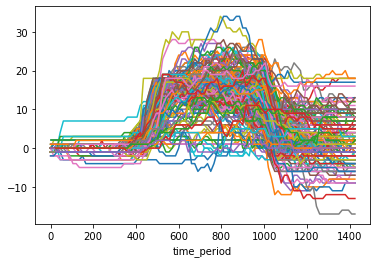

In [57]:
piv5.xs(6) \
    .pivot_table(index='time_period', columns='day_of_year', values='cumi_net') \
    .plot(legend=False);

Mean REU profile:

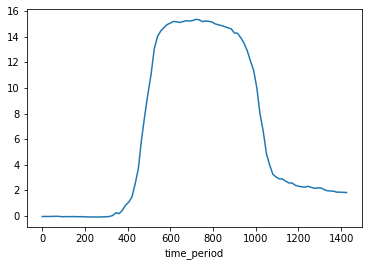

In [58]:
piv5.xs(6) \
    .pivot_table(index='time_period', columns='day_of_year', values='cumi_net') \
    .mean(axis=1).plot()

This gives a better intuition for how the REU profile is derived

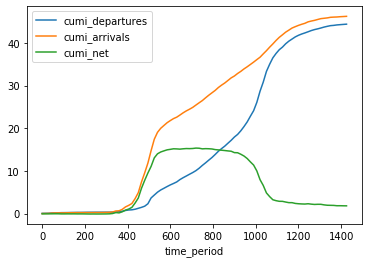

In [65]:
piv5.xs(6).stack().unstack('day_of_year').mean(axis=1).unstack().plot()

This gives an example of a station with a negative profile: Waterloo 3

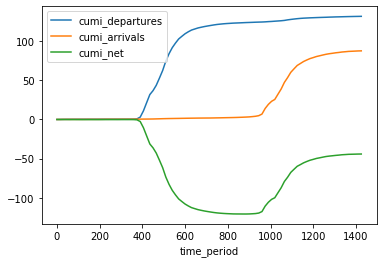

In [66]:
piv5.xs(361).stack().unstack('day_of_year').mean(axis=1).unstack().plot()

Time_period quantile plots: illustrating variance in profiles over the year

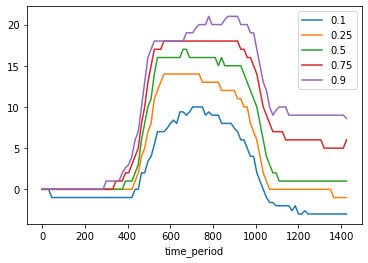

In [59]:
piv5.xs(6).pivot_table(index='time_period', columns='day_of_year', values='cumi_net') \
    .quantile([0.1, 0.25, 0.5, 0.75, 0.9],axis=1) \
    .transpose().plot()

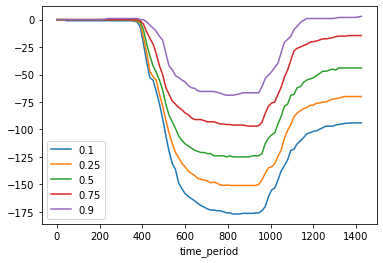

In [60]:
piv5.xs(361).pivot_table(index='time_period', columns='day_of_year', values='cumi_net') \
    .quantile([0.1, 0.25, 0.5, 0.75, 0.9],axis=1) \
    .transpose().plot()

Knightsbridge (one way Hyde Park traffic)

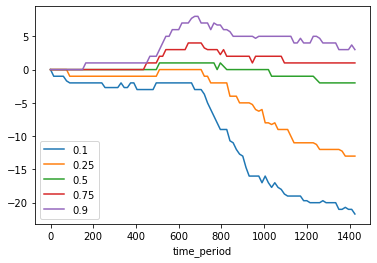

In [68]:
piv5.xs(222).pivot_table(index='time_period', columns='day_of_year', values='cumi_net') \
    .quantile([0.1, 0.25, 0.5, 0.75, 0.9],axis=1) \
    .transpose().plot()

So in the examples above:
* Broadcasting house should start the day with at least 20 docks spare, and potentially have a bike or two spare. 
* Waterloo3 would start with 100-175 bike spare, and does not require spare docks

So I think this implies:
* asbolute of minimum gives the the number of bikes required if it is below zero. 
* maximum gives the number of docks required if it is positive. 
* ergo: amplitude / range gives the total capacity ideally required. 
* difference between start and end gives required rebalancing overnight: 
    * negative delta: station needs to be topped-up with bikes
    * positive delta: station needs bikes removing
    
A conservative approach is to: 
* take the max of a higher quantile (e.g. 0.75) for required docks
* take the min of a lower quantile (e.g. 0.25) for required bikes.
* ...Which will give a wider margin. 

### Extracting Key Points of Interest

In [71]:
piv6 = piv5.pivot_table(index=['station','time_period'], columns='day_of_year', values='cumi_net')

In [72]:
piv6.head()

day_of_year          1    2    3    4    5    6    7    8    9    10   ...  \
station time_period                                                    ...   
1       0            0.0  0.0  0.0  0.0  NaN  NaN  0.0  0.0  0.0 -1.0  ...   
        15           0.0  0.0  0.0  0.0  NaN  NaN  0.0  0.0  0.0 -1.0  ...   
        30           0.0  0.0  0.0  0.0  NaN  NaN  0.0  0.0  0.0 -1.0  ...   
        45           0.0  0.0  0.0  0.0  NaN  NaN  0.0  0.0  0.0 -1.0  ...   
        60           0.0  0.0  0.0  0.0  NaN  NaN  0.0  0.0  0.0 -1.0  ...   

day_of_year          356  357  358  359  360  361  362  363  364  365  
station time_period                                                    
1       0            NaN  0.0  0.0  0.0  0.0  0.0  NaN  NaN  0.0  0.0  
        15           NaN  0.0  0.0  0.0 -2.0  0.0  NaN  NaN  0.0  0.0  
        30           NaN  0.0  0.0  0.0 -3.0  0.0  NaN  NaN  0.0  0.0  
        45           NaN  0.0  0.0  0.0 -3.0  0.0  NaN  NaN  0.0  0.0  
        60           NaN  0.0  0.0  0.0 -3.0  0.0  NaN  NaN  0.0  0.0  

[5 rows x 365 columns]

In [87]:
summary_df = pd.DataFrame(index=piv6.index)

In [88]:
summary_df['mean_net'] = piv6.mean(axis=1)
summary_df['q1'] = piv6.quantile(0.25, axis=1)
summary_df['q3'] = piv6.quantile(0.75, axis=1)

In [89]:
summary_df

mean_net   q1   q3
station time_period                    
1       0            0.007547  0.0  0.0
        15           0.000000  0.0  0.0
        30           0.003774  0.0  0.0
        45           0.003774  0.0  0.0
        60           0.003774  0.0  0.0
...                       ...  ...  ...
839     1365         1.830116 -2.0  5.0
        1380         1.907336 -2.0  5.0
        1395         1.872587 -2.0  5.0
        1410         1.818533 -2.0  5.0
        1425         1.779923 -2.0  5.0

[75840 rows x 3 columns]

In [93]:
bike_kpis = pd.DataFrame(index=summary_df.index.unique(level='station'))

,mean_net,q1,q3
station,,,
1,-8.154717,-11.0,-5.00
2,0.611321,-4.0,5.00
3,10.053640,2.0,16.00
4,4.123596,-1.0,10.00
5,4.832700,-1.0,11.00
...,...,...,...
834,-1.317797,-4.0,2.00
835,-0.544000,-1.0,1.75
836,-4.464000,-8.0,0.00


In [141]:
def extract_kpis():
    time_maxima = summary_df.groupby('station').max()
    time_minima = summary_df.groupby('station').min()
    bike_kpis['mean docks needed'] = time_maxima['mean_net'].clip(lower=0)
    bike_kpis['conservative docks needed'] = time_maxima.max(axis=1).clip(lower=0)
    
    bike_kpis['mean bikes needed'] = abs(time_minima['mean_net'].clip(upper=0))
    bike_kpis['conservative bikes needed'] = abs(time_minima.min(axis=1).clip(upper=0))
    
    bike_kpis['mean midnight delta'] = (summary_df.xs(1425,level='time_period') - summary_df.xs(0,level='time_period'))['mean_net'] 
    
    bike_kpis['mean capacity needed'] = bike_kpis['mean bikes needed'] + bike_kpis['mean docks needed']
    bike_kpis['conservative capacity needed'] = bike_kpis['conservative bikes needed'] + bike_kpis['conservative docks needed']

extract_kpis()

In [142]:
bike_kpis.loc[6]

mean bikes needed                0.079245
conservative bikes needed        1.000000
mean docks needed               15.362264
conservative docks needed       18.000000
mean midnight delta              1.875472
mean capacity needed            15.441509
conservative capacity needed    19.000000
Name: 6, dtype: float64

In [143]:
bike_kpis.loc[361]

mean bikes needed               120.651685
conservative bikes needed       151.000000
mean docks needed                 0.000000
conservative docks needed         0.000000
mean midnight delta             -44.063670
mean capacity needed            120.651685
conservative capacity needed    151.000000
Name: 361, dtype: float64

TODO: Some of the pivoting you've been doing could have been done more succinctly with groupbys

In [114]:
bike_kpis_int = bike_kpis.round(0).astype(int)

In [144]:
outputdir = Path('tfl_project/data/analytical_outputs/reu')
if not outputdir.exists():
    outputdir.mkdir(parents=True)
bike_kpis_int.to_csv(outputdir / 'bikepoint_reu_inferences.csv')

In [121]:
summary_df.to_csv(outputdir / 'bikepoint_reu_profiles.csv')

# Further Exploration
## Join to metadata

In [137]:
metadata = pd.read_sql_query("SELECT * FROM station_metadata WHERE bikepoint_id > 0", db)

In [145]:
df = metadata.merge(bike_kpis,left_on='bikepoint_id' ,right_index=True)

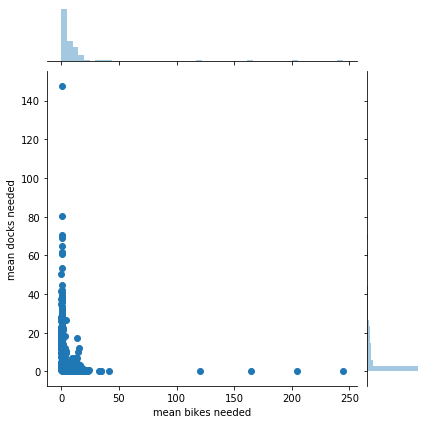

In [128]:
sns.jointplot(data=df, x='mean bikes needed', y='mean docks needed')

In [147]:
df[(df['mean docks needed'] > 60) | (df['mean bikes needed'] > 30)]

,bikepoint_id,max_capacity,median_capacity,common_name,latitude,longitude,avg_5am_docked,mean bikes needed,conservative bikes needed,mean docks needed,conservative docks needed,mean midnight delta,mean capacity needed,conservative capacity needed
13,14,48,46,"Belgrove Street , King's Cross",51.529943,-0.123616,36.0,204.203636,257.000000,0.000000,14.00000,-2.909091,204.203636,271.000000
24,25,50,50,"Doric Way , Somers Town",51.528833,-0.132250,41.0,34.573034,43.000000,0.000000,0.50000,-8.779026,34.573034,43.500000
43,45,26,26,"Boston Place, Marylebone",51.522511,-0.162298,22.0,41.059701,50.000000,0.194030,0.19403,-13.246269,41.253731,50.194030
63,66,40,40,"Holborn Circus, Holborn",51.517950,-0.108657,1.0,0.225191,0.225191,147.690840,187.75000,62.412214,147.916031,187.975191
68,71,34,33,"Newgate Street , St. Paul's",51.515418,-0.098850,1.0,0.330827,0.330827,80.484962,103.00000,18.259398,80.815789,103.330827
106,109,57,57,"Soho Square , Soho",51.515631,-0.132328,2.0,0.664179,1.000000,70.757463,87.00000,26.623134,71.421642,88.000000
149,154,35,35,"Waterloo Station 3, Waterloo",51.503791,-0.112824,30.0,244.151515,267.000000,0.000000,9.00000,-7.128788,244.151515,276.000000
206,214,32,32,"Endsleigh Gardens, Euston",51.526838,-0.130504,26.0,32.295880,41.000000,0.000000,3.50000,-5.333333,32.295880,44.500000
220,228,40,40,"St. James's Square, St. James's",51.507424,-0.134621,1.0,0.281955,0.281955,64.609023,74.75000,29.909774,64.890977,75.031955
242,251,34,34,"Brushfield Street, Liverpool Street",51.518908,-0.079249,1.0,0.306569,1.000000,68.762774,90.75000,31.930657,69.069343,91.750000


## Compare Actual capacity with Suggested capacity

In [258]:
def real_vs_derived(xlim=None, ylim=None, label_ratio=2):
    
    df_sub = df.copy()
    
    xcol = 'max_capacity'
    ycol = 'mean capacity needed'
    
    if xlim:
        df_sub =df_sub[df_sub[xcol] <= xlim]
    if ylim:
        df_sub =df_sub[df_sub[ycol] <= ylim]
    
    more_needed = df_sub[df_sub[xcol] < df_sub[ycol]]
    
    fig, ax = plt.subplots()
    ax.scatter(data=df_sub, x=xcol, y=ycol, alpha=0.3)
    ax.set(xlabel='Real Life Capacity')
    ax.set(ylabel='REU-derived capacity')
    
    if xlim:
        ax.set(xlim=(0,xlim))
    if ylim:
        ax.set(ylim=(0, ylim))
    
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()

    ax.plot([x0,x1], [x0, x1], color='grey', linestyle='--', linewidth='1')

    ax.scatter(data=more_needed, x=xcol, y=ycol, color='orange', alpha=0.5)
    
    for x, y, t in more_needed[[xcol, ycol, 'common_name']].values:
        if y/x > label_ratio:
            ax.annotate(t, (x,y))
        
    return fig, ax

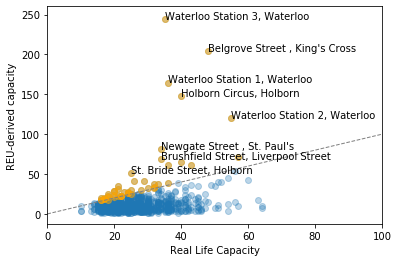

In [259]:
real_vs_derived(xlim=100);

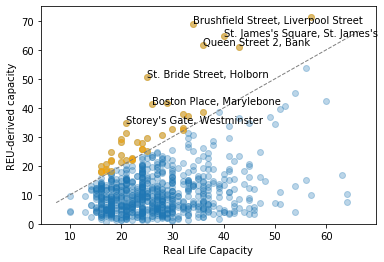

In [260]:
fig, _ = real_vs_derived(ylim=75, label_ratio=1.5)